# Experiment Parameter Tuning 
This notebook loads JSON logs and plots test accuracy vs. epoch for different parameter values,
showing mean ± standard deviation shading across runs.

In [1]:
import os
import re
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

⚠️ Skipping invalid JSON on line 601
⚠️ Skipping invalid JSON on line 603
⚠️ Skipping invalid JSON on line 605
⚠️ Skipping invalid JSON on line 607


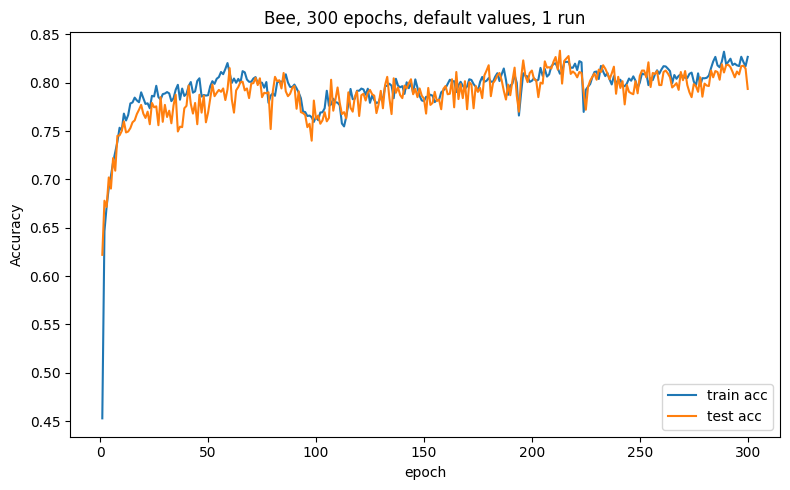

In [18]:
filepath = '../logs/output.txt' 
epochs_train, acc_train = [], []
epochs_test,  acc_test  = [], []

with open(filepath, 'r') as f:
    for lineno, line in enumerate(f, start=1):
        line = line.strip()
        if not line:
            continue

        try:
            rec = json.loads(line)
        except json.JSONDecodeError:
            print(f"⚠️ Skipping invalid JSON on line {lineno}")
            continue

        if not isinstance(rec, dict):
            continue

        mode = rec.get('mode')
        if mode == 'train':
            epochs_train.append(rec['epoch'])
            acc_train.append(rec['acc'])
        elif mode == 'test':
            epochs_test.append(rec['epoch'])
            acc_test.append(rec['acc'])

plt.figure(figsize=(8,5))
plt.plot(epochs_train, acc_train, linestyle='-',  label='train acc')
plt.plot(epochs_test,  acc_test, linestyle='-', label='test acc')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Bee, 300 epochs, default values, 1 run')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:

def collect_runs(logs_dir, timestamp_dir, param_name):
    base = os.path.join(logs_dir, timestamp_dir)
    pattern = os.path.join(base, f"{param_name}*_run*")
    run_dirs = glob.glob(pattern)
    results = {}
    for rd in run_dirs:
        name = os.path.basename(rd)
        m = re.match(rf"{re.escape(param_name)}(.+?)_run(\d+)", name)
        if not m:
            continue
        val_str, run_id = m.groups()
        try:
            val = int(val_str)
        except ValueError:
            val = float(val_str)
        json_path = os.path.join(rd, f"{name}.json")
        if not os.path.isfile(json_path):
            print(f"⚠️ Missing JSON: {json_path}")
            continue
        data = json.load(open(json_path, 'r'))
        test_entries = sorted(
            [e for e in data if e.get('mode') == 'test'],
            key=lambda e: e['epoch']
        )
        accs = [e['acc'] for e in test_entries]
        results.setdefault(val, []).append(accs)
    return results

def plot_param_tuning(results, param_name):
    plt.figure(figsize=(8,5))
    for val, runs in sorted(results.items()):
        arr = np.array(runs)
        mean = arr.mean(axis=0)
        std  = arr.std(axis=0)
        epochs = np.arange(1, mean.shape[0]+1)
        plt.plot(epochs, mean, label=f"{param_name}={val}")
        plt.fill_between(epochs, mean-std, mean+std, alpha=0.2)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy')
    plt.title(f"Tuning {param_name} in human-like communication")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Run the Analysis
Set your parameters below and execute this cell to generate the plot.

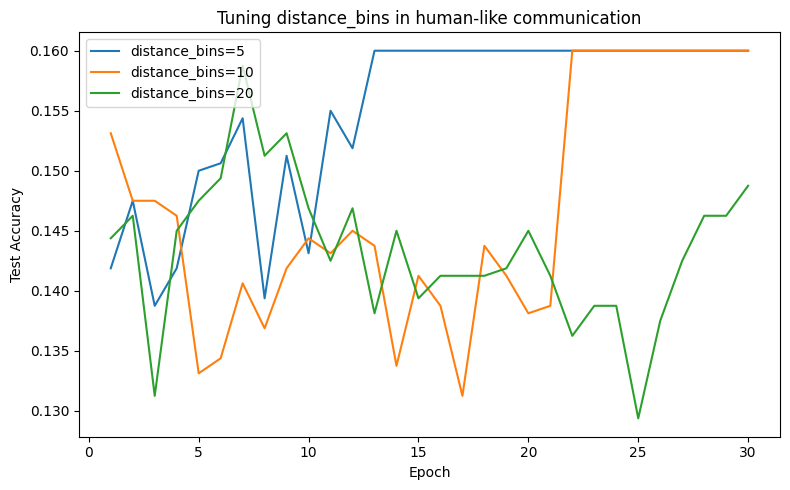

In [47]:
root     = '../logs'
timestamp_dir = '20250507_125930'
param_name    = 'distance_bins'

# Collect runs and plot
results = collect_runs(root, timestamp_dir, param_name)
if not results:
    raise RuntimeError('No runs found. Check your folder names and paths.')
plot_param_tuning(results, param_name)